In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, array_to_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
import numpy as np


In [ ]:
# Load the DIV2K dataset
(train_ds, train_info) = tfds.load('div2k', split='train', with_info=True, as_supervised=True)
(valid_ds, valid_info) = tfds.load('div2k', split='validation', with_info=True, as_supervised=True)

In [ ]:
for lr_image, hr_image in train_ds.take(1):
    print("Loaded LR image shape:", lr_image.shape)
    print("Loaded HR image shape:", hr_image.shape)

Loaded LR image shape: (678, 1020, 3)
Loaded HR image shape: (1356, 2040, 3)


In [ ]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

def process_input(input_image, input_size, upscale_factor):
    input_image = tf.image.rgb_to_yuv(input_image)
    last_dimension_axis = len(input_image.shape) - 1
    y, u, v = tf.split(input_image, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")

def process_target(input_image):
    input_image = tf.image.rgb_to_yuv(input_image)
    last_dimension_axis = len(input_image.shape) - 1
    y, u, v = tf.split(input_image, 3, axis=last_dimension_axis)
    return y

def preprocess_and_process_div2k(lr_image, hr_image):
    # Resize the HR image to the desired crop size (squeezing the original image)
    hr_image_squeezed = tf.image.resize(hr_image, [crop_size, crop_size])

    # Simulate the LR image by resizing the squeezed HR image down and back up
    lr_image = tf.image.resize(hr_image_squeezed, [input_size, input_size])
    lr_image = tf.image.resize(lr_image, [crop_size, crop_size])

    # Normalize both images to [0, 1]
    hr_image_squeezed = tf.cast(hr_image_squeezed, tf.float32) / 255.0
    lr_image = tf.cast(lr_image, tf.float32) / 255.0

    # Apply additional processing
    lr_image_processed = process_input(lr_image, input_size, upscale_factor)
    hr_image_processed = process_target(hr_image_squeezed)

    return lr_image_processed, hr_image_processed

# Apply preprocessing and additional processing to the training dataset
train_ds = train_ds.map(preprocess_and_process_div2k, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Apply preprocessing and additional processing to the validation dataset
valid_ds = valid_ds.map(preprocess_and_process_div2k, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Low-resolution Image:


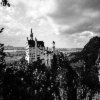

High-resolution Image:


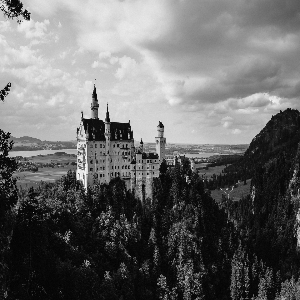

Low-resolution Image:


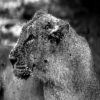

High-resolution Image:


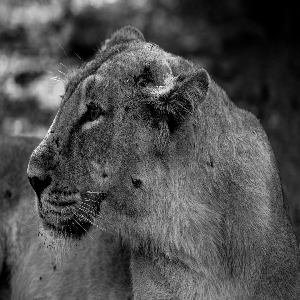

Low-resolution Image:


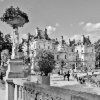

High-resolution Image:


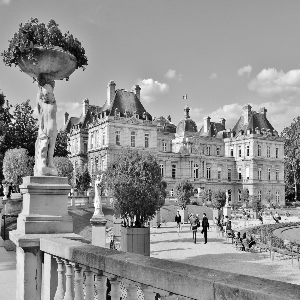

Low-resolution Image:


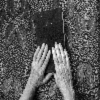

High-resolution Image:


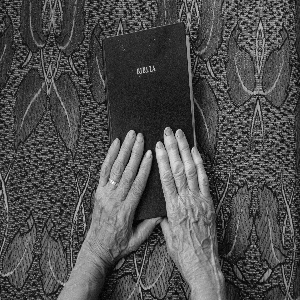

Low-resolution Image:


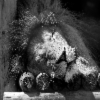

High-resolution Image:


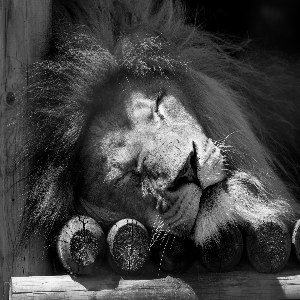

Low-resolution Image:


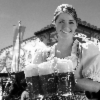

High-resolution Image:


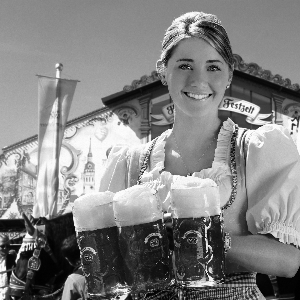

Low-resolution Image:


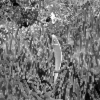

High-resolution Image:


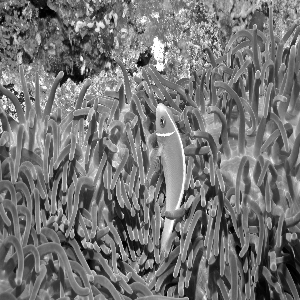

Low-resolution Image:


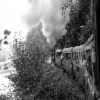

High-resolution Image:


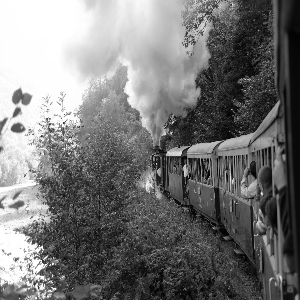

In [ ]:
for batch in train_ds.take(1):
    for lr_image, hr_image in zip(batch[0], batch[1]):
        print("Low-resolution Image:")
        display(array_to_img(lr_image))
        print("High-resolution Image:")
        display(array_to_img(hr_image))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras import Input
from tensorflow.keras import initializers

class DepthToSpace(layers.Layer):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = tf.shape(input)[0], tf.shape(input)[1], tf.shape(input)[2], tf.shape(input)[3]
        depth = depth // (self.block_size ** 2)

        x = tf.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = tf.transpose(x, [0, 1, 3, 2, 4, 5])
        x = tf.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x



In [ ]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": initializers.Orthogonal(),
        "padding": "same",
    }
    inputs = Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = DepthToSpace(upscale_factor)(x)

    return Model(inputs, outputs)


In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
import PIL

# Helper Functions

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    x1, x2, y1, y2 = 200, 300, 100, 200
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(f"{prefix}-{title}.png")
    plt.show()

def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )

def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [ ]:
# Custom Callback
class ESPCNCallback(Callback):
    def __init__(self, test_img_path, upscale_factor):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_path), upscale_factor)

    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * np.log10(1 / logs["loss"]))

In [ ]:
# Model Configuration

checkpoint_filepath = "/tmp/checkpoint.keras"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

early_stopping_callback = EarlyStopping(monitor="loss", patience=10)


In [ ]:
# Assuming get_model is defined elsewhere and returns the model
upscale_factor = 3
model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(test_img_path='/content/original_image.png', upscale_factor=upscale_factor),
             early_stopping_callback,
             model_checkpoint_callback]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, None, None, 1)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, None, None, 64)      │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, None, None, 32)      │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, None, None, 9)       │           2,601 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depth_to_space_4 (DepthToSpace)      │ (None, None, None, 1)       │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,657 (233.04 KB)

 Trainable params: 59,657 (233.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
Mean PSNR for epoch: 19.08
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


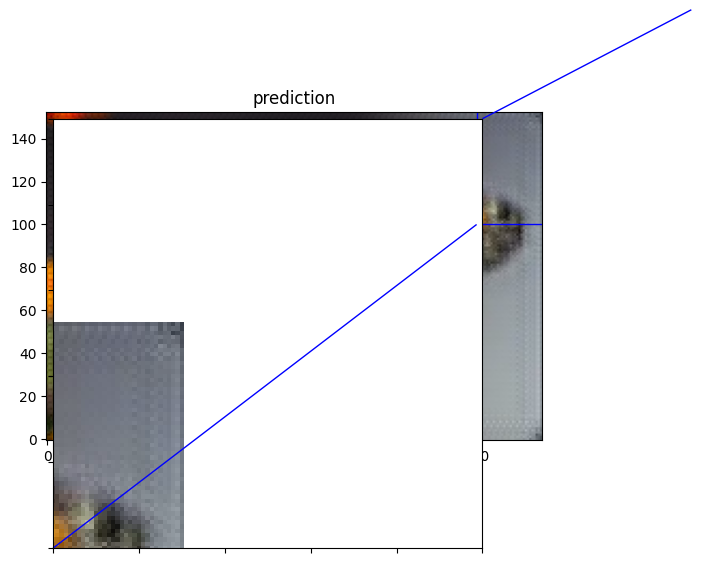

100/100 - 16s - 161ms/step - loss: 0.0311 - val_loss: 0.0116
Epoch 2/100
Mean PSNR for epoch: 19.46
100/100 - 13s - 134ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 3/100
Mean PSNR for epoch: 19.61
100/100 - 13s - 135ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 4/100
Mean PSNR for epoch: 19.66
100/100 - 14s - 135ms/step - loss: 0.0097 - val_loss: 0.0101
Epoch 5/100
Mean PSNR for epoch: 19.68
100/100 - 14s - 136ms/step - loss: 0.0096 - val_loss: 0.0101
Epoch 6/100
Mean PSNR for epoch: 19.70
100/100 - 13s - 134ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 7/100
Mean PSNR for epoch: 19.71
100/100 - 13s - 134ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 8/100
Mean PSNR for epoch: 19.72
100/100 - 13s - 134ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 9/100
Mean PSNR for epoch: 19.72
100/100 - 13s - 135ms/step - loss: 0.0095 - val_loss: 0.0100
Epoch 10/100
Mean PSNR for epoch: 19.73
100/100 - 13s - 135ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 11/100
Mean PSNR for epoch: 19.7

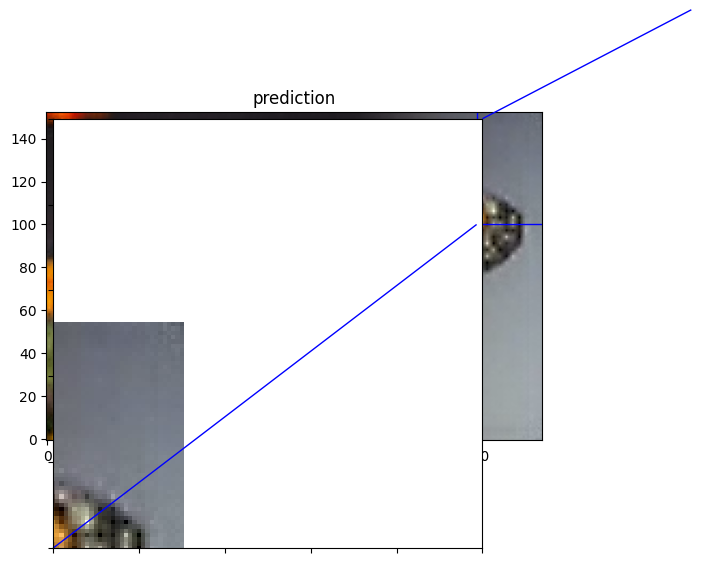

100/100 - 14s - 141ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 22/100
Mean PSNR for epoch: 19.78
100/100 - 14s - 136ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 23/100
Mean PSNR for epoch: 19.79
100/100 - 13s - 134ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 24/100
Mean PSNR for epoch: 19.79
100/100 - 14s - 136ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 25/100
Mean PSNR for epoch: 19.79
100/100 - 13s - 134ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 26/100
Mean PSNR for epoch: 19.79
100/100 - 14s - 135ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 27/100
Mean PSNR for epoch: 19.80
100/100 - 14s - 136ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 28/100
Mean PSNR for epoch: 19.80
100/100 - 14s - 136ms/step - loss: 0.0093 - val_loss: 0.0098
Epoch 29/100
Mean PSNR for epoch: 19.80
100/100 - 13s - 134ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 30/100
Mean PSNR for epoch: 19.80
100/100 - 14s - 136ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 31/100
Mean PSNR for epo

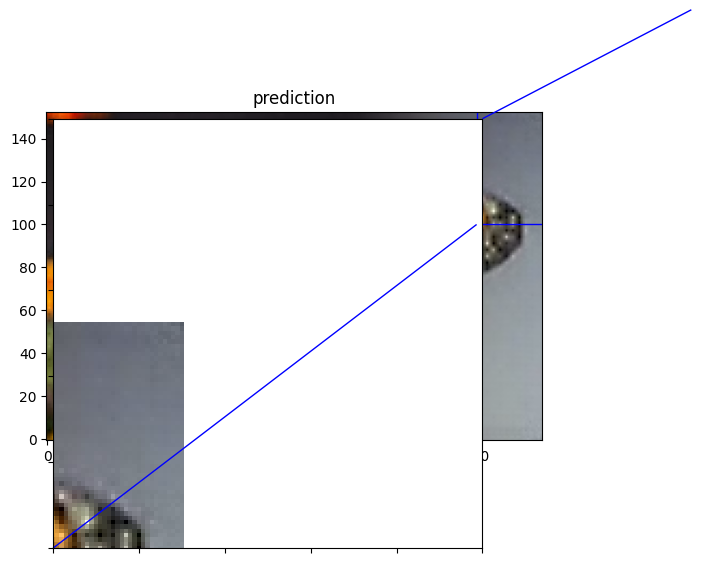

100/100 - 14s - 139ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 42/100
Mean PSNR for epoch: 19.82
100/100 - 13s - 135ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 43/100
Mean PSNR for epoch: 19.83
100/100 - 14s - 135ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 44/100
Mean PSNR for epoch: 19.83
100/100 - 14s - 135ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 45/100
Mean PSNR for epoch: 19.83
100/100 - 13s - 135ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 46/100
Mean PSNR for epoch: 19.83
100/100 - 13s - 134ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 47/100
Mean PSNR for epoch: 19.83
100/100 - 14s - 135ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 48/100
Mean PSNR for epoch: 19.83
100/100 - 13s - 134ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 49/100
Mean PSNR for epoch: 19.83
100/100 - 13s - 135ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 50/100
Mean PSNR for epoch: 19.83
100/100 - 13s - 134ms/step - loss: 0.0092 - val_loss: 0.0097
Epoch 51/100
Mean PSNR for epo

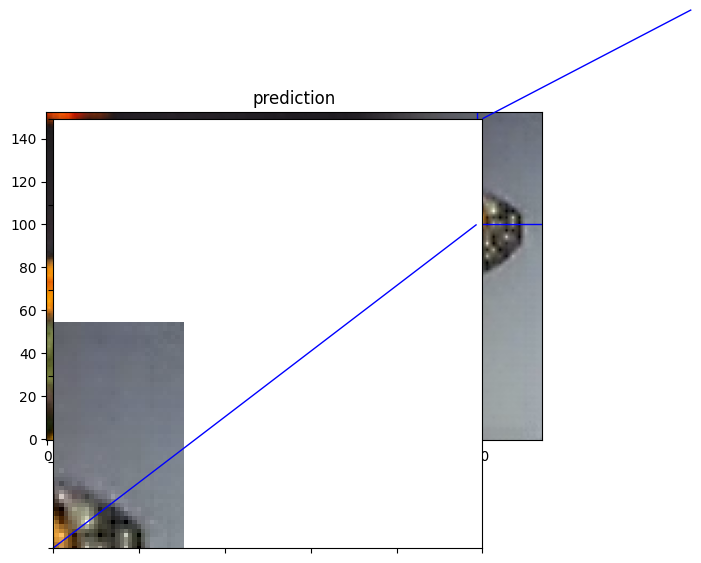

100/100 - 14s - 140ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 62/100
Mean PSNR for epoch: 19.84
100/100 - 14s - 136ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 63/100
Mean PSNR for epoch: 19.85
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 64/100
Mean PSNR for epoch: 19.85
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 65/100
Mean PSNR for epoch: 19.85
100/100 - 13s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 66/100
Mean PSNR for epoch: 19.85
100/100 - 13s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 67/100
Mean PSNR for epoch: 19.85
100/100 - 14s - 136ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 68/100
Mean PSNR for epoch: 19.85
100/100 - 13s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 69/100
Mean PSNR for epoch: 19.85
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 70/100
Mean PSNR for epoch: 19.85
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 71/100
Mean PSNR for epo

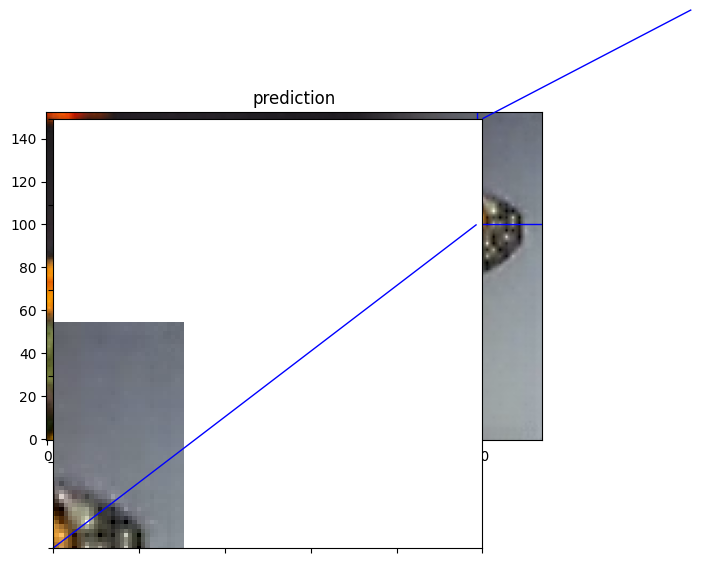

100/100 - 14s - 140ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 82/100
Mean PSNR for epoch: 19.87
100/100 - 14s - 137ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 83/100
Mean PSNR for epoch: 19.87
100/100 - 13s - 134ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 84/100
Mean PSNR for epoch: 19.87
100/100 - 13s - 134ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 85/100
Mean PSNR for epoch: 19.87
100/100 - 14s - 136ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 86/100
Mean PSNR for epoch: 19.87
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 87/100
Mean PSNR for epoch: 19.87
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 88/100
Mean PSNR for epoch: 19.87
100/100 - 13s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 89/100
Mean PSNR for epoch: 19.87
100/100 - 14s - 137ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 90/100
Mean PSNR for epoch: 19.87
100/100 - 14s - 135ms/step - loss: 0.0091 - val_loss: 0.0096
Epoch 91/100
Mean PSNR for epo

In [ ]:
model.fit(
    train_ds, epochs=100, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

model.load_weights(checkpoint_filepath)
model.save("final_model.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


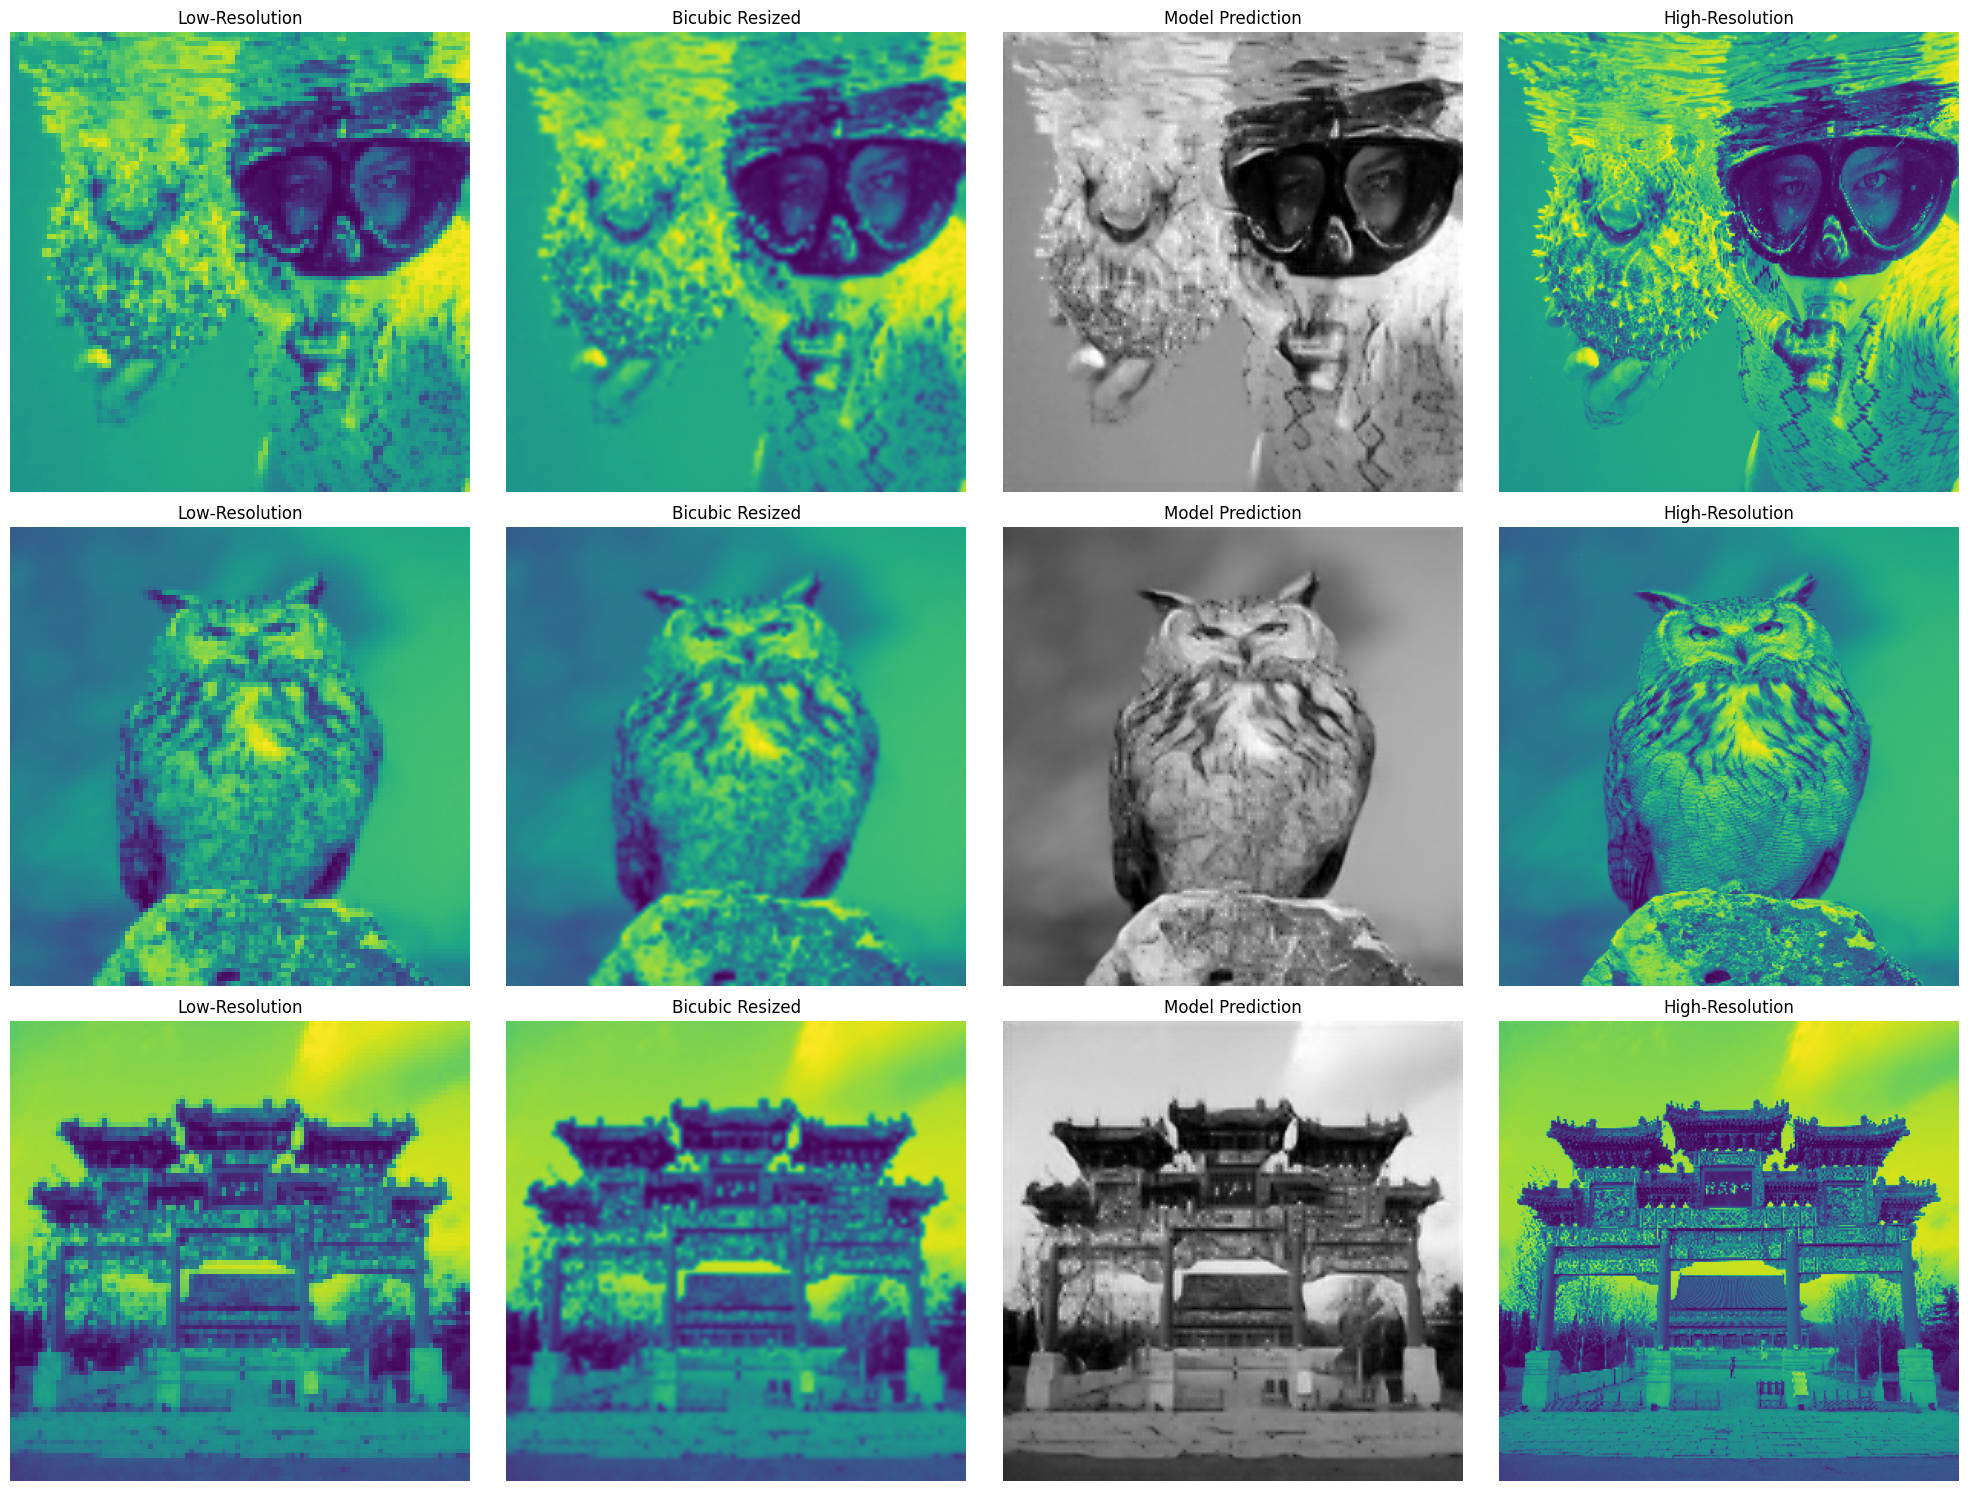

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to display images in a grid
def display_comparisons(val_images, model, upscale_factor, num_rows=2):
    random_indices = np.random.choice(len(val_images), num_rows, replace=False)

    fig, axes = plt.subplots(num_rows, 4, figsize=(20, 5 * num_rows))

    for row_index, index in enumerate(random_indices):
        lr_image, hr_image = val_images[index]
        lr_image, hr_image = lr_image[0], hr_image[0]  # Get the first image from the batch

        # Convert tensor images to PIL images
        lr_image_pil = array_to_img(lr_image)
        hr_image_pil = array_to_img(hr_image)

        # Generate the model's prediction
        prediction_pil = upscale_image(model, lr_image_pil)

        # If the prediction is grayscale, convert to RGB
        if prediction_pil.mode != 'RGB':
            prediction_rgb = prediction_pil.convert("RGB")
        else:
            prediction_rgb = prediction_pil

        # Resize low-res image to the high-res size using standard bicubic resizing for comparison
        bicubic_resized_pil = lr_image_pil.resize(hr_image_pil.size, Image.BICUBIC)

        # Display the images
        images_to_display = [
            ("Low-Resolution", lr_image_pil),
            ("Bicubic Resized", bicubic_resized_pil),
            ("Model Prediction", prediction_rgb),
            ("High-Resolution", hr_image_pil)
        ]

        for col_index, (title, img) in enumerate(images_to_display):
            axes[row_index, col_index].imshow(img)
            axes[row_index, col_index].set_title(title)
            axes[row_index, col_index].axis('off')

    plt.tight_layout()
    plt.show()

# Assuming the validation dataset is already loaded
val_images = list(valid_ds)  # Convert the validation dataset to a list of images and labels

# Display comparisons for a few random validation images
display_comparisons(val_images, model, upscale_factor=3, num_rows=3)  # Adjust num_rows as needed
